In [6]:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

In this file, I use PA-NODE's to learn a hystersis loop composed of saddle node bifurcations. This file differs from 3 as multiple initial conditions are used as training data rather than a single trajector (as used in version 3).

#### Neural ODE

In [8]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out


In [9]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, domain, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(input_dim, hidden_layers, depth, output_dim*(num_breakpoints+1), activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = input_dim
        self.num_breakpoint     = num_breakpoints
        self.domain             = domain
        self.num_A              = (num_breakpoints+1)*output_dim
        self.breakpoints        = torch.linspace(domain[0], domain[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
        self.k = 1  #steepness parameter for sigmoid function
    
    
    def sigmoid(self, x):
       out = torch.sigmoid(self.k*x)
       return out
    


    def forward(self, t, x):
        out = self.network(x)

        #Getting indicator function
        #index = torch.where(self.break_params < t)[0].shape[0]
        #indicator = torch.concatenate([ torch.sigmoid(self.break_params - t)*((t < self.break_params).float()), torch.sigmoid(t - self.break_params)*((t > self.break_params).float())])
        #print(indicator); print('Break Param:', self.break_params)
        
        
        #First interval 
        i1 = self.sigmoid(self.break_params[0] - t).unsqueeze(0)
        output = i1

        #Internal Intervals
        for i in range(0, self.break_params.shape[0]-1):
            a = self.sigmoid(t - self.break_params[i]).unsqueeze(0)
            b = self.sigmoid(self.break_params[i+1] - t).unsqueeze(0)
            c = a*b
            output = torch.concatenate([output, c])
            
        #Final interval 
       
    
        i_final = self.sigmoid(t - self.break_params[-1]).unsqueeze(0)

        output = torch.cat([output, i_final])
     
        indicator = output
       
      
        out2 = out*indicator
      
        
        

        #out[0] = out[0]*(t < self.break_params).float()
        #out[1] = out[1]*(t >= self.break_params).float()
        final_out = torch.sum(out2, dim=0)
       

        return final_out.unsqueeze(0)
    
  

#### Model

In [10]:
class SaddleNodeHysteresis:
    def __init__(self, r):
        #Setting system parameters
        self.r = r
    

    #Differential Equation
    def f(self, t, x):
        xdot = (self.r(t)*2 - 1) + x - x**3

        return xdot

In [11]:
k = 6
s_k = lambda t: torch.sigmoid(torch.tensor(k*t)).detach().numpy()

   

In [12]:
parameter_f = lambda t: 2*(s_k(t-6.0)*s_k(18.0 - t) ) -1


In [13]:
parameter_f(2)

np.float32(-1.0)

In [14]:
2*parameter_f(np.arange(0.0, 30.0, 0.01))-1

array([-3., -3., -3., ..., -3., -3., -3.], shape=(3000,))

In [15]:
x= np.vectorize(parameter_f)(np.arange(0.0, 30.0, 0.01))

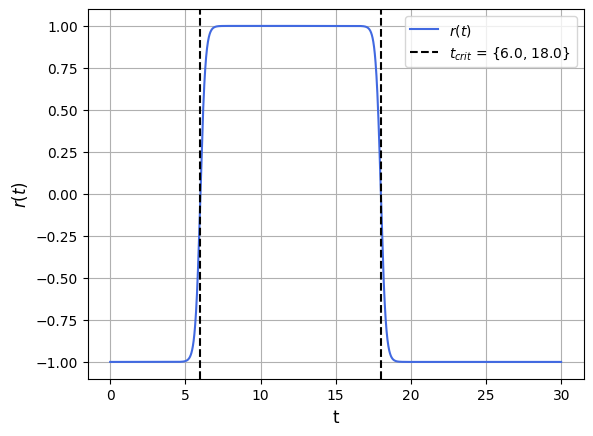

In [16]:
t = np.arange(0.0, 30.0, 0.01)
plt.plot(t, x, color='royalblue', label=r'$r(t)$')
plt.grid()
plt.xlabel('t', fontsize=12)
plt.ylabel(r'$r(t)$', fontsize=12)
plt.axvline(x=6.0, color='k', linestyle='--', label=r'$t_{crit}$ = {6.0, 18.0}')
plt.axvline(x=18.0, color='k', linestyle='--')

plt.legend()

In [17]:
saddlenode = SaddleNodeHysteresis(r = parameter_f)

##### Solve IVP

In [18]:
t_Start = 0; t_Final =30; dt = 0.05; t_Eval = np.arange(t_Start, t_Final, dt)

In [19]:
y0 = 2

In [20]:
output = int.solve_ivp(saddlenode.f, t_span=(t_Start, t_Final), y0=[-1],
                        method = 'RK45', t_eval = t_Eval)
data1 = output.y


AttributeError: type object 'int' has no attribute 'solve_ivp'

In [21]:
plt.plot(t_Eval, data1[0, :], color='royalblue', label = 'Ground Truth')

NameError: name 'data1' is not defined

In [22]:
t_eval = np.arange(t_Start, t_Final, dt)
x_eval = np.arange(-2, 2, 0.01)


x, y = np.meshgrid(t_eval, x_eval)
f = np.vectorize(saddlenode.f)(t=x, x=y)

In [23]:
np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :])

NameError: name 'output' is not defined

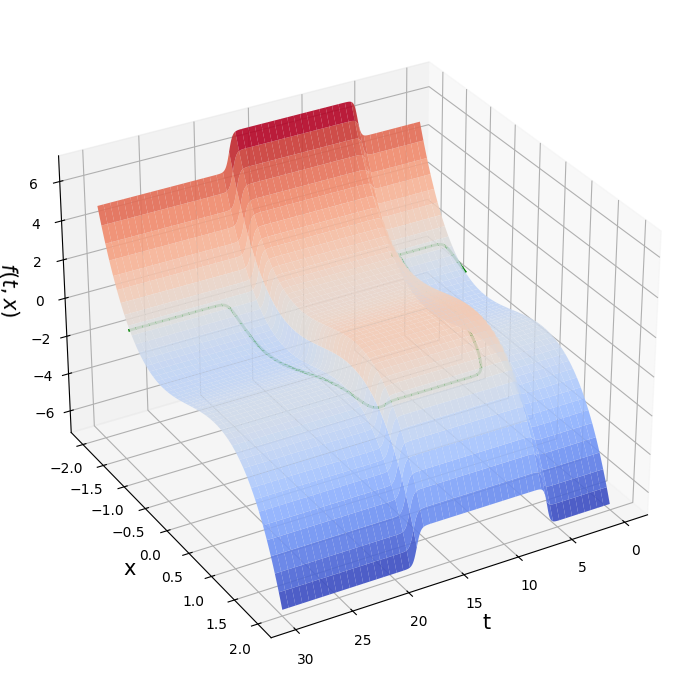

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(10,7))
plt.tight_layout()

ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_zlabel(r'$f(t, x)$', fontsize=15)

cmap = cm.coolwarm
ax.plot(t_eval, output.y[0,:], np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'g', linewidth = 2 )
surf = ax.plot_surface(x, y, f, norm=colors.CenteredNorm(), cmap=cmap, alpha=0.9)

ax.view_init(elev = 30, azim = 60)
#ax.plot(xs=t_eval, ys=output.y[0,:], zs=np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'black', linewidth = 5 )
#fig.colorbar(surf)
plt.show()

#### Training 

In [ ]:
#Batching function
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list
        
data1_tensor = torch.tensor(data1)
t_eval_tensor = torch.tensor(t_Eval)

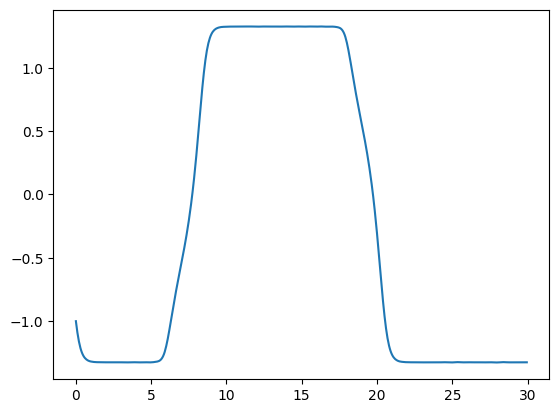

In [ ]:
plt.plot(t_eval_tensor, data1_tensor[0, :])

##### Model Parameters

In [ ]:
data1.shape

(1, 600)

In [ ]:
# Model + Training Setup
model = Piecewise_Auto_NODE(input_dim=1, hidden_layers=2, depth = 15, output_dim=1, domain = [t_Start, t_Final], num_breakpoints=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
model.k = 1

batch_length = 100; batch_size = 5
loss_list = []

In [ ]:
##### Starting Functions

In [ ]:
pred_x = odeint(func = model, y0 = torch.tensor([2.0]), t = torch.arange(t_Start, t_Final, dt), method='rk4', options={'step_size': dt})
a, b = batch(data1_tensor.T, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)

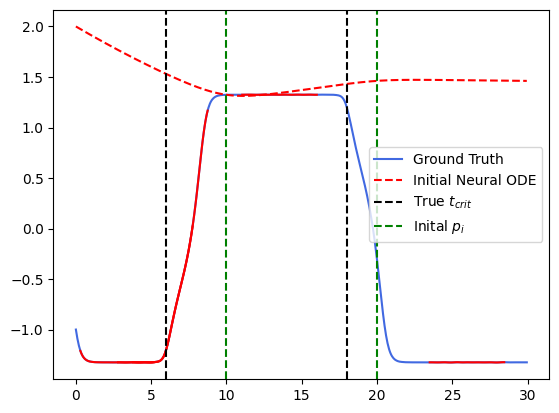

In [ ]:
plt.plot(t_Eval, data1[0, :], color='royalblue', label = 'Ground Truth')
plt.plot(t_Eval,  pred_x.detach().numpy(), color='r', linestyle='--',  label='Initial Neural ODE')
for i in range(0, batch_size):
    plt.plot(b[i].detach().numpy(), a[i].detach().numpy(), color='red')

plt.axvline(x = 6.0, color='k', linestyle='--', label='True '+r'$t_{crit}$')
plt.axvline(x = 18.0, color='k', linestyle='--')

plt.axvline(x = model.break_params[0].detach().numpy(), color='g', linestyle='--', label='Inital '+r'$p_{i}$')
plt.axvline(x = model.break_params[1].detach().numpy(), color='g', linestyle='--')

plt.legend()

In [ ]:
torch.autograd.set_detect_anomaly(False)

##### Training Loop

In [ ]:
optimizer.zero_grad()
pred_x = odeint(model, torch.tensor([2.0]).float(), t_eval_tensor.float(), method='rk4', options={'step_size': dt})
train_loss = loss_fn(pred_x, data1_tensor.T.float())

In [ ]:
train_loss.backward()
optimizer.step()

In [ ]:
print('Total Loss: ', train_loss)
print('')
print('Breakpoint: ', model.break_params)
print('')
print('Gradient of Breakpoint: ', model.break_params.grad)

Total Loss:  tensor(4.7613, grad_fn=<MseLossBackward0>)

Breakpoint:  Parameter containing:
tensor([10.0100, 19.9900], requires_grad=True)

Gradient of Breakpoint:  tensor([-0.1688,  0.0401])


In [ ]:
data1_tensor[0, 0]

tensor(-1., dtype=torch.float64)

In [ ]:
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(data1_tensor.T, t_eval_tensor, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model, torch.tensor([-1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x, data1_tensor.T)
                loss_list.append(train_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_28784\257724121.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x, torch.tensor(batch_i))
  0%|          | 1/1000 [00:15<4:14:41, 15.30s/it]

Epoch 0, Loss: 0.002326043384569022


 10%|█         | 101/1000 [03:37<32:51,  2.19s/it] 

Epoch 100, Loss: 0.0035878577216259355


 20%|██        | 201/1000 [06:49<33:33,  2.52s/it]

Epoch 200, Loss: 0.0011789118011946594


 30%|███       | 301/1000 [10:12<31:12,  2.68s/it]

Epoch 300, Loss: 0.0009950452819935617


 40%|████      | 401/1000 [13:00<20:39,  2.07s/it]

Epoch 400, Loss: 0.0005713564888028308


 50%|█████     | 501/1000 [15:28<17:24,  2.09s/it]

Epoch 500, Loss: 0.00211796719072517


 60%|██████    | 601/1000 [17:54<13:08,  1.98s/it]

Epoch 600, Loss: 0.00045734916899178336


 70%|███████   | 701/1000 [20:18<09:51,  1.98s/it]

Epoch 700, Loss: 0.0003908179034444772


 80%|████████  | 801/1000 [22:44<06:32,  1.97s/it]

Epoch 800, Loss: 0.0006048460788226445


 90%|█████████ | 901/1000 [25:08<03:15,  1.97s/it]

Epoch 900, Loss: 0.0006940906688973048


100%|██████████| 1000/1000 [27:29<00:00,  1.65s/it]


##### Analysis

In [ ]:
with torch.no_grad():
        pred_x = odeint(model, torch.tensor([-1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})
        train_loss = loss_fn(pred_x, data1_tensor.T)
        #loss_list.append(train_loss.item())

In [372]:
train_loss

tensor(0.0016, dtype=torch.float64)

In [320]:
import Plot3D as plot3d

Text(0.5, 0, 'Epochs')

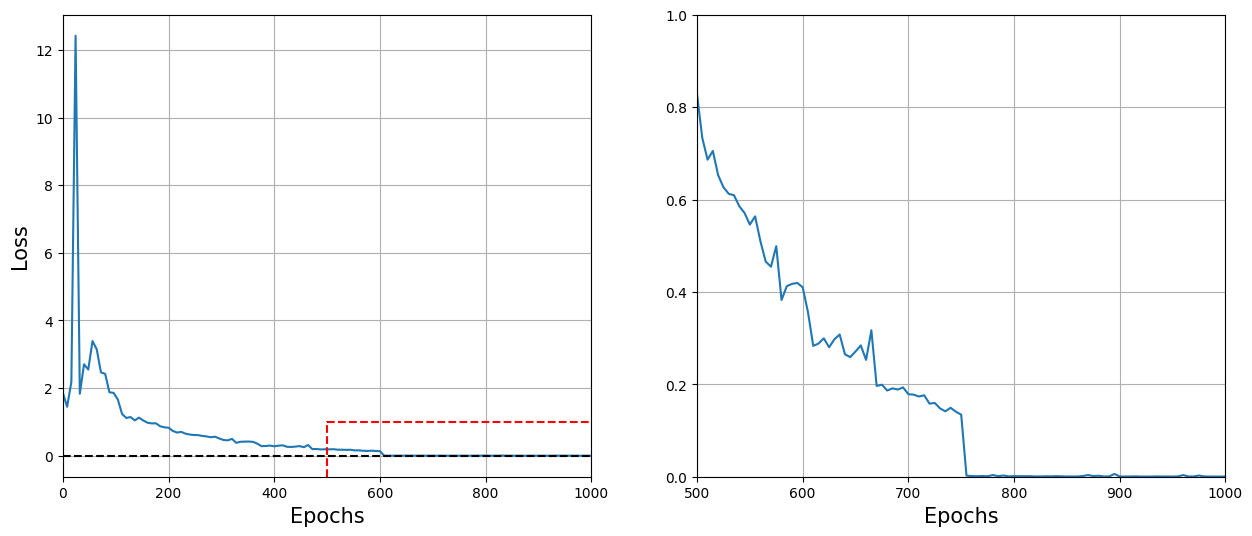

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, 1000, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.axvline(x=500, color='r', linestyle='--', ymax=0.12)
ax.axhline(y=1, color='r', linestyle='--', xmin=0.5)
ax.axhline(y=0, color='k', linestyle='--')
ax.set_xlim(0, 1000)

ax2 = fig.add_subplot(1, 2, 2)


ax2.plot(np.linspace(500, 1000, len(loss_list)-25), loss_list[25:] )
ax2.grid()
ax2.set_ylim(0, 1)
ax2.set_xlim(500, 1000)


ax2.set_xlabel('Epochs', fontsize=15)


In [500]:
e_pts = np.linspace(0, 1000, len(loss_list))

In [506]:
np.log(loss_list[1:])

array([ 0.36962045,  0.77961279,  2.51935356,  0.60648779,  0.99507994,
        0.93523849,  1.22092205,  1.14666326,  0.9027362 ,  0.88343455,
        0.62955044,  0.61996344,  0.50612202,  0.20963968,  0.11003804,
        0.13505488,  0.04459959,  0.11841493,  0.04210684, -0.02321435,
       -0.04524463, -0.04191655, -0.13634711, -0.17564317, -0.18840893,
       -0.31018241, -0.37651774, -0.34938201, -0.42670028, -0.46710589,
       -0.49033437, -0.4955986 , -0.53532755, -0.56050794, -0.60565454,
       -0.57351239, -0.67384733, -0.76411887, -0.78836962, -0.69496958,
       -0.96100939, -0.88555612, -0.87356496, -0.86891319, -0.89166626,
       -1.03166757, -1.26191544, -1.24367387, -1.20556477, -1.2722188 ,
       -1.21264851, -1.1782952 , -1.32836643, -1.35142624, -1.30551227,
       -1.25824207, -1.37484681, -1.14890927, -1.62696379, -1.61361463,
       -1.67894498, -1.65424858, -1.66712798, -1.64341524, -1.72244534,
       -1.72803378, -1.75059652, -1.73563267, -1.84393768, -1.83

Text(0.5, 0, 'Epochs')

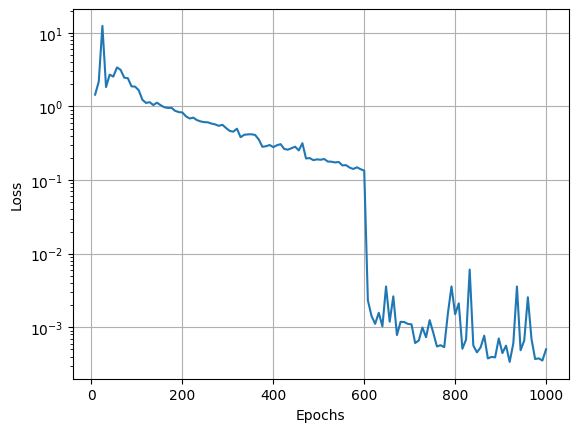

In [523]:
plt.plot(e_pts[1:], loss_list[1:])
plt.grid()
#plt.xscale('log')
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")

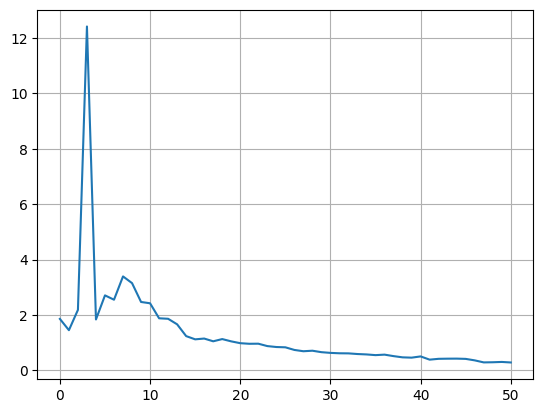

In [ ]:

plt.plot(loss_list)

plt.grid()

In [452]:
pred_x = odeint(model, torch.tensor([-1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})

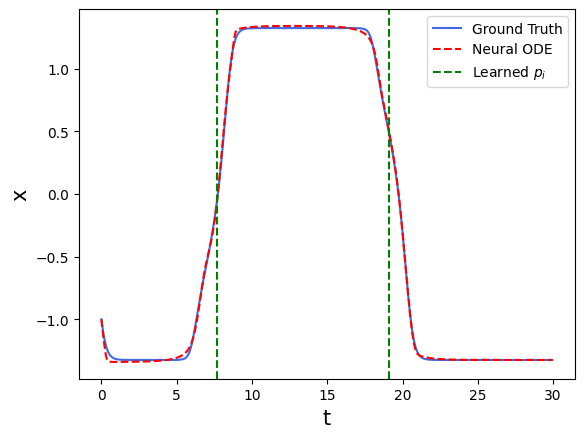

In [495]:
plt.plot(t_Eval, data1[0, :], color='royalblue', label = 'Ground Truth')
plt.plot(t_Eval,  pred_x.detach().numpy(), color='r', linestyle='--', label='Neural ODE')
plt.xlabel('t', fontsize=15)
plt.ylabel('x', fontsize=15)


#plt.axvline(x = 6.0, color='k', linestyle='--', label='True '+r'$t_{crit}$')
#plt.axvline(x = 18.0, color='k', linestyle='--')


#plt.axvline(x = 3, color='k', linestyle='--', label='True '+r'$t_{crit}$')
plt.axvline(x = model.break_params[0].detach().numpy(), color='g', linestyle='--', label='Learned '+r'$p_i$')
plt.axvline(x = model.break_params[1].detach().numpy(), color='g', linestyle='--')
#plt.axvline(x = model.break_params.detach().numpy(), color='green', linestyle='--', label='Learned '+r'$t_{crit}$')
plt.legend()

In [147]:
model.break_params


Parameter containing:
tensor([2.8805, 6.0115, 8.9011], requires_grad=True)

In [163]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[1.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y

##### Plotting Phase Space

In [464]:
t_Final

30

In [5]:
t_eval = np.arange(t_Start, t_Final, dt)
x_eval = np.arange(-10, 10, 0.01)
t, x = np.meshgrid(t_eval, x_eval)
f_hat = np.vectorize(saddlenode.f)(t=x, x=y)


NameError: name 't_Start' is not defined

In [455]:
def f_hat_func(t, x):
    a = model.forward(t, torch.tensor([x], dtype=torch.float32)).detach().numpy()
    return a
    

f_hat = np.vectorize(f_hat_func)(t=t, x=x)

(400, 600)

In [456]:
pred_x = odeint(model, torch.tensor([-1.0]), t_eval_tensor, method='rk4', options={'step_size': 0.01})

In [465]:
f_hat_func_vector = np.vectorize(f_hat_func)
a = pred_x.detach().numpy().flatten()
traj1 = f_hat_func_vector(t=t_eval, x=a)

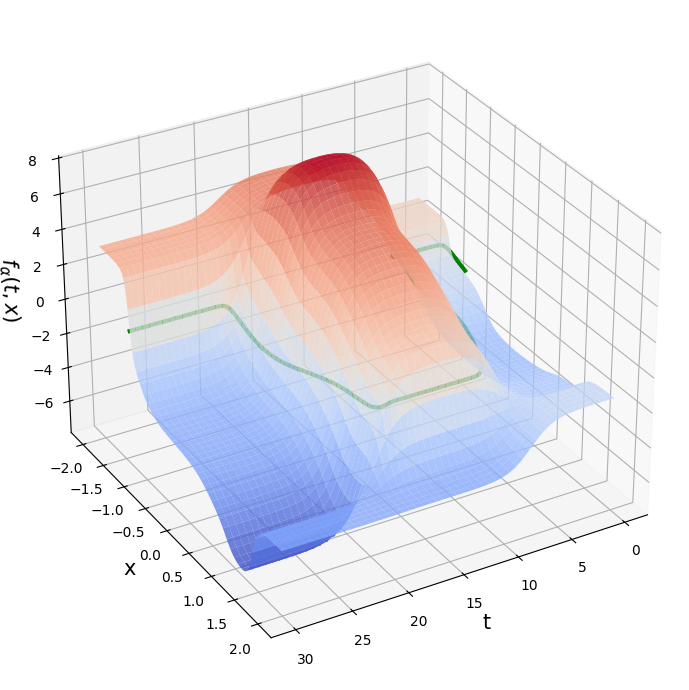

In [473]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(10,7))
plt.tight_layout()

ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_zlabel(r'$f_{\alpha}(t, x)$', fontsize=15)

cmap = cm.coolwarm
ax.plot(t_eval, output.y[0,:], np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'g', linewidth = 3 )
surf = ax.plot_surface(t, x, f_hat, norm=colors.CenteredNorm(), cmap=cmap, alpha=0.8)

ax.view_init(elev = 30, azim = 60)
#ax.plot(xs=t_eval, ys=pred_x.detach().numpy().flatten(), zs=traj1, color = 'g', linewidth = 3 )
#fig.colorbar(surf)
plt.show()

In [ ]:
def f_hat_func(t, x):
    a = model.forward(t, torch.tensor([x], dtype=torch.float32)).detach().numpy()
    return a
    

f_hat = np.vectorize(f_hat_func)(t=t, x=x)

In [423]:
t_eval = np.arange(t_Start, t_Final, dt)
x_eval = np.arange(-5, 5, 0.05)
t, x = np.meshgrid(t_eval, x_eval)
f_hat_new = np.vectorize(f_hat_func)(t=t, x=x)


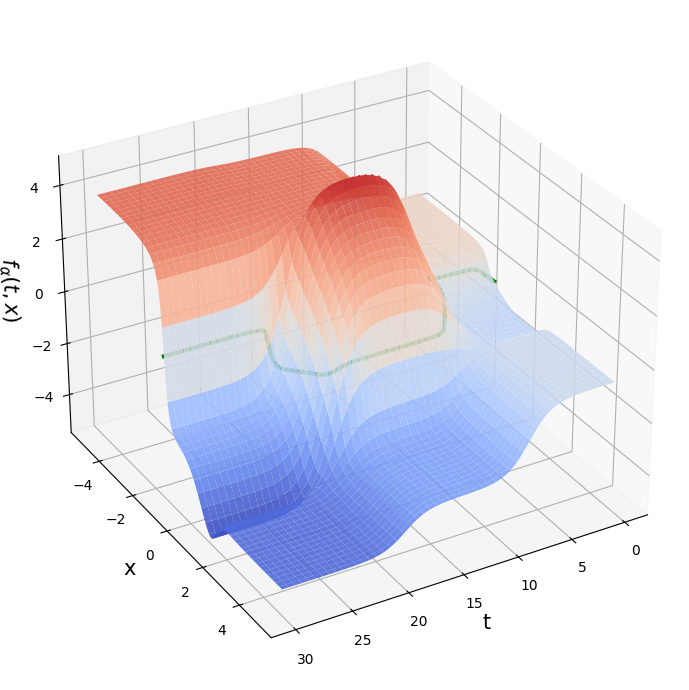

In [424]:
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(10,7))
plt.tight_layout()

ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('x', fontsize=15)
ax.set_zlabel(r'$f_{\alpha}(t, x)$', fontsize=15)

cmap = cm.coolwarm
#ax.plot(t_eval, output.y[0,:], np.vectorize(saddlenode.f)(t=t_eval, x=output.y[0, :]), color = 'g', linewidth = 2 )
surf = ax.plot_surface(t, x, f_hat_new, norm=colors.CenteredNorm(), cmap=cmap, alpha=0.9)

ax.view_init(elev = 30, azim = 60)
ax.plot(xs=t_eval, ys=pred_x.detach().numpy().flatten(), zs=traj1, color = 'g', linewidth = 3 )
#fig.colorbar(surf)
plt.show()

### Bifurcation Diagram